In [1]:
from tda_helper import *
import torch
from torch.utils.data import TensorDataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

torch.set_printoptions(precision=6)

In [2]:
# dimension
d = 2
# number of Gaussians in the mixture
K = 3
# number of points per cluster
N = 50

# for plotting
cmap = plt.get_cmap('gist_rainbow')
cNorm  = mpl.colors.Normalize(vmin=0, vmax=K)
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
colors = scalarMap.to_rgba(range(K))

data = []
labels = []
# random centroids in [-5,5]x[-5, 5]
means = 10*(np.random.rand(K, d)-0.5)
# random covariances
covs = 0.1*np.random.rand(K, d, d)
for k in range(K):
    # this is indeed a covariance matrix
    covs[k] = 0.3*np.dot(covs[k], covs[k].T)+0.7*0.1*np.eye(d)
    data.append([np.random.multivariate_normal(means[k], covs[k], N)])
    labels.append([k,]*N)
    
data = torch.FloatTensor(np.concatenate(data, axis=1).squeeze())
labels = np.array(labels).flatten()

### Normalization
data = (data-torch.mean(data, axis=0)) / torch.std(data, axis=0)

In [3]:
config_layers = {
    'input_size': data.shape[1],
    'hidden_size_enc': 128,
    'n_layers_enc': 2,
    'hidden_size_dec': 128,
    'n_layers_dec': 2,
    'emb_size': 2,
    'activation': 'ReLU',
    'bias': False,
}

use_cuda = False
lr = 0.01
tol = 1e-6
batch_size = 150
n_epochs = 20

target_penalty = 1.0
compactness_penalty = 0.0
# goal is to maximize 1-homology, i.e produce more cycles im the latent space
homology_dim = 1
homology_penalty = -0.01
homology_eps = 0.0
normalize_for_homology = '01'

In [4]:
model_no_penalty = AutoencoderHom(config_layers, 
                                  tol=tol,
                                  lr=lr,
                                  batch_size=batch_size,
                                  use_cuda=use_cuda,
                                  target_penalty=1.0,
                                 )

model_no_penalty.train(data, n_epochs)

model = AutoencoderHom(config_layers, 
                       tol=tol,
                       lr=lr,
                       batch_size=batch_size,
                       use_cuda=use_cuda,
                       target_penalty=target_penalty,
                       homology_penalty=homology_penalty,
                       homology_dim=homology_dim,
                       normalize_for_homology=normalize_for_homology,
                       homology_eps=homology_eps,
                       compactness_penalty=compactness_penalty,
                      )

model.train(data, n_epochs)

Epoch : 1/20: 100%|█| 1.00/1.00 [00:00<00:00, 157it/s, homology=0, compactness=33.6, reconstruction=0.977]
Epoch : 2/20: 100%|█| 1.00/1.00 [00:00<00:00, 213it/s, homology=0, compactness=97.4, reconstruction=0.668]
Epoch : 3/20: 100%|█| 1.00/1.00 [00:00<00:00, 204it/s, homology=0, compactness=165, reconstruction=0.271]
Epoch : 4/20: 100%|█| 1.00/1.00 [00:00<00:00, 183it/s, homology=0, compactness=232, reconstruction=0.157]
Epoch : 5/20: 100%|█| 1.00/1.00 [00:00<00:00, 210it/s, homology=0, compactness=250, reconstruction=0.118]
Epoch : 6/20: 100%|█| 1.00/1.00 [00:00<00:00, 81.6it/s, homology=0, compactness=252, reconstruction=0.149]
Epoch : 7/20: 100%|█| 1.00/1.00 [00:00<00:00, 159it/s, homology=0, compactness=253, reconstruction=0.158]
Epoch : 8/20: 100%|█| 1.00/1.00 [00:00<00:00, 219it/s, homology=0, compactness=253, reconstruction=0.0878]
Epoch : 9/20: 100%|█| 1.00/1.00 [00:00<00:00, 218it/s, homology=0, compactness=254, reconstruction=0.0237]
Epoch : 10/20: 100%|█| 1.00/1.00 [00:00<0

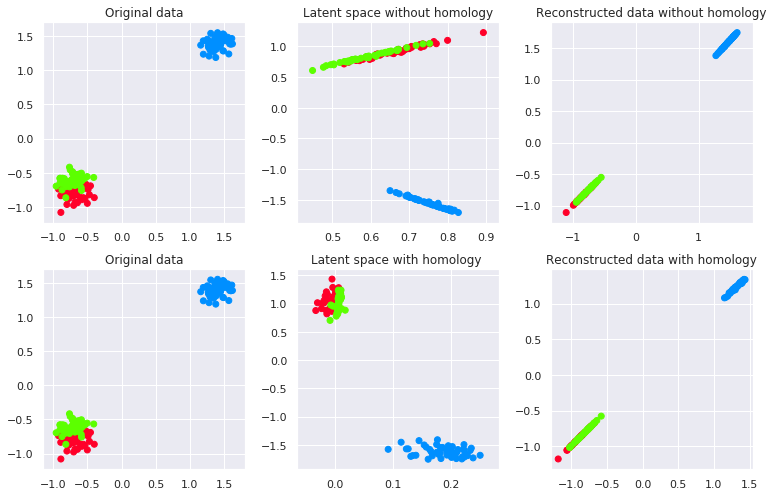

In [5]:
fig, axes = plt.subplots(figsize=(11, 7), nrows=2, ncols=3)

data = data.to(model.device)
data_plot = data.cpu().data

ax = axes[0, 0]
ax.scatter(data_plot[:, 0], data_plot[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Original data')

ax = axes[0, 1]
latent_space = model_no_penalty.autoencoder.encoder(data).cpu().data
ax.scatter(latent_space[:, 0], latent_space[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space without homology')

ax = axes[0, 2]
reconstructed_data = model_no_penalty.autoencoder(data).cpu().data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Reconstructed data without homology')

ax = axes[1, 0]
ax.scatter(data_plot[:, 0], data_plot[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Original data')

ax = axes[1, 1]
latent_space = model.autoencoder.encoder(data).cpu().data
ax.scatter(latent_space[:, 0], latent_space[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space with homology ')

ax = axes[1, 2]
reconstructed_data = model.autoencoder(data).cpu().data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Reconstructed data with homology')

plt.tight_layout()
plt.show()